In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import h5py, json
import os,time,sys
from sklearn.ensemble import RandomForestClassifier
from importlib import reload
sys.path.append('/content/drive/MyDrive/Colab Notebooks/fidle-master')
import fidle.pwk as pwk
run_dir = '/content/drive/MyDrive/Colab Notebooks'


In [ ]:
# ---- About dataset (no need to change)
#
dataset_dir      = '/content/drive/MyDrive/Colab Notebooks'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'synop-LYSpluie.csv'
schema_filename  = 'synoppluie.json'
features         = ['Précipitations dans la dernière heure','Précipitations dans les 3 dernières heures','Précipitations dans les 6 dernières heures', 
'Précipitations dans les 12 dernières heures','Précipitations dans les 24 dernières heures']
features_len     = len(features)

# ---- About training
#
iterations       = 56        # number of iterations for prediction (1 iteration = 3h)

scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 32       # Sequence len

In [ ]:
pwk.override('iterations', 'scale', 'train_prop', 'sequence_len')

In [ ]:
# ---- Read dataset

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]

# ---- Normalize, and convert to numpy array
mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = np.array( (dataset_train - mean) / std )
dataset_test  = np.array( (dataset_test  - mean) / std )

print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

Dataset       :  (32704, 7)
Train dataset :  (26163, 5)
Test  dataset :  (6541, 5)


In [ ]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/best_model.h7')

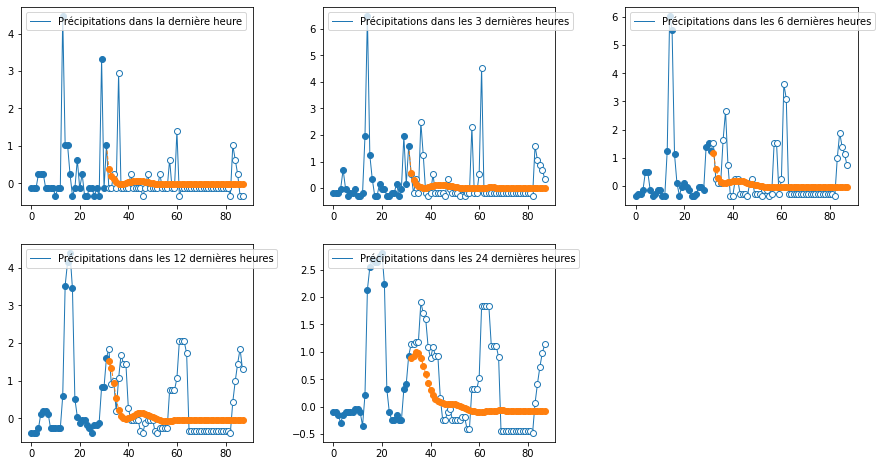

In [ ]:
# ---- Initial sequence

s=random.randint(0,len(dataset_test)-sequence_len-iterations)

sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

# ---- Iterate on 4 predictions

sequence_pred=list(sequence_pred)



for i in range(iterations):
    sequence=sequence_pred[-sequence_len:]
    pred = loaded_model.predict( np.array([sequence]) )
    sequence_pred.append(pred[0])

# ---- Extract the predictions    

pred=np.array(sequence_pred[-iterations:])
       
# ---- Show result

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='01-prediction-norm')

In [ ]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


def get_prediction(dataset, model, iterations=56,sequence_len=32):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

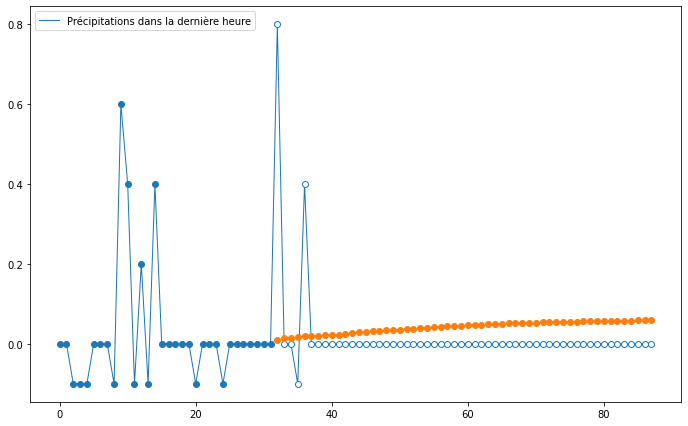

In [ ]:
  sequence_true, pred = get_prediction(dataset_test, loaded_model,iterations=56)

feat=0

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features,
                            only_features=[feat],width=14, height=8, save_as='02-prediction')